In [1]:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.7 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654617 sha256=725682368995ca1f228521388f84316101f527ad9fc82baaa79c1549a03ee61b
  Stored in directory: /root/.cache/pip/wheels/07/8b/b7/570cb90b10f17e85ccb291ba1f04af41ec697745104a2263eb
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 3.1.1
    Uninstalling cloudpickle-3.1.1:
      Successfully uninstalled cloudpickle-3.1.1
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.12.1 requires cloud

In [2]:
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from __future__ import division

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Activation, Flatten, Convolution2D, Permute, Input,
                                     SeparableConv2D, Lambda, Subtract, Add, Conv2D,
                                     DepthwiseConv2D, BatchNormalization, ReLU, InputLayer)
#from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

import tensorflow.keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

import os
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import time
from tensorflow.keras.callbacks import Callback
from rl.callbacks import FileLogger


import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import json
from datetime import datetime
from google.colab import drive

In [3]:
# Parámetros
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

# Entorno
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [4]:
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

In [1]:
# Configuración inicial
class Processor:
    def process_observation(self, observation):
        raise NotImplementedError
    def process_state_batch(self, batch):
        raise NotImplementedError
    def process_reward(self, reward):
        raise NotImplementedError
    def process_action(self, action):
        return action
    def process_info(self, info):
        return info



# Configurar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


In [ ]:
# Red Neuronal
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Calcular el tamaño de la salida de las capas convolucionales
        self._feature_size = self._get_conv_output(input_shape)

        self.fc1 = nn.Linear(self._feature_size, 512)
        self.fc2 = nn.Linear(512, n_actions)

    def _get_conv_output(self, shape):
        # Aquí shape es (channels, H, W)
        o = self.conv1(torch.zeros(1, *shape))
        o = self.conv2(o)
        o = self.conv3(o)
        return int(np.prod(o.size()))

    def forward(self, x):
        # Normalizar los valores de los píxeles a [0, 1]
        x = x.float() / 255.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Aplanar la salida
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Implementamos las distintas piezas de la solución DQN
class AtariWrapper(gym.Wrapper):
    def __init__(self, env, processor, skip=4, obs_shape=(84, 84), stack_size=4):
        super(AtariWrapper, self).__init__(env)
        self.env = env
        self.processor = processor
        self.skip = skip # Frame skipping
        self.obs_shape = obs_shape
        self.stack_size = stack_size
        self.frames = deque([], maxlen=stack_size) # Búfer para apilar frames
        # La observación tendrá la forma (stack_size, obs_shape[0], obs_shape[1])
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(stack_size, obs_shape[0], obs_shape[1]), dtype=np.uint8
        )

    def reset(self):
        obs = self.env.reset()
        obs = self.processor.process_observation(obs) # Preprocesar
        for _ in range(self.stack_size):
            self.frames.append(obs)
        return self._get_observation()

    def step(self, action):
        total_reward = 0.0
        done = False
        info = {}
        for _ in range(self.skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += self.processor.process_reward(reward) # Procesar recompensa
            if done:
                break

        obs = self.processor.process_observation(obs) # Preprocesar
        self.frames.append(obs)

        return self._get_observation(), total_reward, done, info

    def _get_observation(self):
        # Apilar los frames para crear la observación multicanal
        return np.stack(self.frames, axis=0)

In [ ]:
# Agente
class DQNAgent:
    def __init__(self, state_shape, n_actions, buffer_size, batch_size, gamma, lr, epsilon_start, epsilon_end, epsilon_decay, target_update_freq):
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq

        self.policy_net = DQN(state_shape, n_actions).to(device)
        self.target_net = DQN(state_shape, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval() # Poner en modo evaluación (no se entrenará)

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = deque(maxlen=buffer_size)
        self.steps_done = 0

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                        np.exp(-1. * self.steps_done / self.epsilon_decay)

        self.epsilon = eps_threshold # Actualizar epsilon para registro si se desea

        if sample > eps_threshold:
            with torch.no_grad():
                # El estado ya viene como (stack_size, H, W) de AtariWrapper
                # Necesitamos añadir la dimensión de batch: (1, stack_size, H, W)
                state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
                return self.policy_net(state_tensor).argmax(1).item()
        else:
            return random.randrange(self.n_actions)

    def store_experience(self, state, action, reward, next_state, done):
        # Los estados ya vienen preprocesados de AtariWrapper en la forma (stack_size, H, W)
        state_t = torch.from_numpy(state).to(device)
        action_t = torch.tensor([action], device=device, dtype=torch.long)
        reward_t = torch.tensor([reward], device=device, dtype=torch.float)
        next_state_t = torch.from_numpy(next_state).to(device) if next_state is not None else None
        done_t = torch.tensor([done], device=device, dtype=torch.bool)

        self.memory.append((state_t, action_t, reward_t, next_state_t, done_t))

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = random.sample(self.memory, self.batch_size)
        batch = list(zip(*transitions))

        # stack los tensores de estados y next_states para formar un batch (batch_size, stack_size, H, W)
        states = torch.stack(batch[0]).to(device)
        actions = torch.cat(batch[1]).to(device)
        rewards = torch.cat(batch[2]).to(device)
        dones = torch.cat(batch[4]).to(device)

        state_action_values = self.policy_net(states).gather(1, actions.unsqueeze(1))

        non_final_mask = ~dones
        # Solo apilar los next_states que no son finales
        non_final_next_states_list = [s for s, d in zip(batch[3], dones) if not d]
        non_final_next_states = torch.stack(non_final_next_states_list).to(device) if non_final_next_states_list else None

        next_state_values = torch.zeros(self.batch_size, device=device)
        if non_final_next_states is not None:
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        expected_state_action_values = (next_state_values * self.gamma) + rewards

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.steps_done += 1

        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

    def load_model(self, path):
        self.policy_net.load_state_dict(torch.load(path, map_location=device))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.policy_net.eval()
        self.target_net.eval()

In [ ]:
# Instanciamos el procesador
atari_processor = AtariProcessor()

# Re-inicializamos el entorno con el wrapper y el procesador
env = AtariWrapper(gym.make(env_name), processor=atari_processor,
                   obs_shape=INPUT_SHAPE, stack_size=WINDOW_LENGTH)
state_shape = env.observation_space.shape # Ahora será (WINDOW_LENGTH, H, W)
n_actions = env.action_space.n
print(f"Estado de entrada a la red: {state_shape}, Número de acciones: {n_actions}")



In [ ]:

# Parámetros de entrenamiento
param_configs = {
    "Config_1_MemOpt": {
        "buffer_size": 2000,
        "batch_size": 32,
        "gamma": 0.99,
        "lr": 0.0001,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 5000,
        "target_update_freq": 500,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_2_MemOpt": {
        "buffer_size": 3000,
        "batch_size": 64,
        "gamma": 0.99,
        "lr": 0.00005,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 7500,
        "target_update_freq": 750,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_3_MemOpt": {
        "buffer_size": 2500,
        "batch_size": 32,
        "gamma": 0.95,
        "lr": 0.0001,
        "epsilon_start": 0.8,
        "epsilon_end": 0.05,
        "epsilon_decay": 4000,
        "target_update_freq": 500,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_4_MemOpt": {
        "buffer_size": 3500,
        "batch_size": 32,
        "gamma": 0.995,
        "lr": 0.0002,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 6000,
        "target_update_freq": 600,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_5_LongerExplore_MemOpt": {
        "buffer_size": 2000,
        "batch_size": 32,
        "gamma": 0.99,
        "lr": 0.0001,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 15000,
        "target_update_freq": 500,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_6_SlowTargetUpdate_MemOpt": {
        "buffer_size": 2000,
        "batch_size": 32,
        "gamma": 0.99,
        "lr": 0.0001,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 5000,
        "target_update_freq": 2000,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_7_HighGamma_LowLR_MemOpt": {
        "buffer_size": 3000,
        "batch_size": 64,
        "gamma": 0.999,
        "lr": 0.00001,
        "epsilon_start": 1.0,
        "epsilon_end": 0.005,
        "epsilon_decay": 7500,
        "target_update_freq": 750,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    },
    "Config_8_LowerGamma_HigherLR_MemOpt": {
        "buffer_size": 2000,
        "batch_size": 32,
        "gamma": 0.98,
        "lr": 0.0005,
        "epsilon_start": 0.9,
        "epsilon_end": 0.02,
        "epsilon_decay": 5000,
        "target_update_freq": 500,
        "total_episodes": 100,
        "max_steps_per_episode": 250,
        "eval_interval": 10
    }
}


In [ ]:
# Guardar resultados
results_dir = "dqn_results"
os.makedirs(results_dir, exist_ok=True)

Usando dispositivo: cpu
Estado de entrada a la red: (4, 84, 84), Número de acciones: 6

--- Iniciando entrenamiento para: Config_1_MemOpt ---
Parámetros: {'buffer_size': 2000, 'batch_size': 32, 'gamma': 0.99, 'lr': 0.0001, 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 5000, 'target_update_freq': 500, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 10.00, Epsilon: 0.1679
Episodio 2/100, Recompensa: 26.00, Epsilon: 0.0100
Episodio 3/100, Recompensa: 21.00, Epsilon: 0.0100
Episodio 4/100, Recompensa: 12.00, Epsilon: 0.0100
Episodio 5/100, Recompensa: 24.00, Epsilon: 0.0100
Episodio 6/100, Recompensa: 20.00, Epsilon: 0.0100
Episodio 7/100, Recompensa: 2.00, Epsilon: 0.0100
Episodio 8/100, Recompensa: 2.00, Epsilon: 0.0100
Episodio 9/100, Recompensa: 6.00, Epsilon: 0.0100
Episodio 10/100, Recompensa: 8.00, Epsilon: 0.0100
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 10.

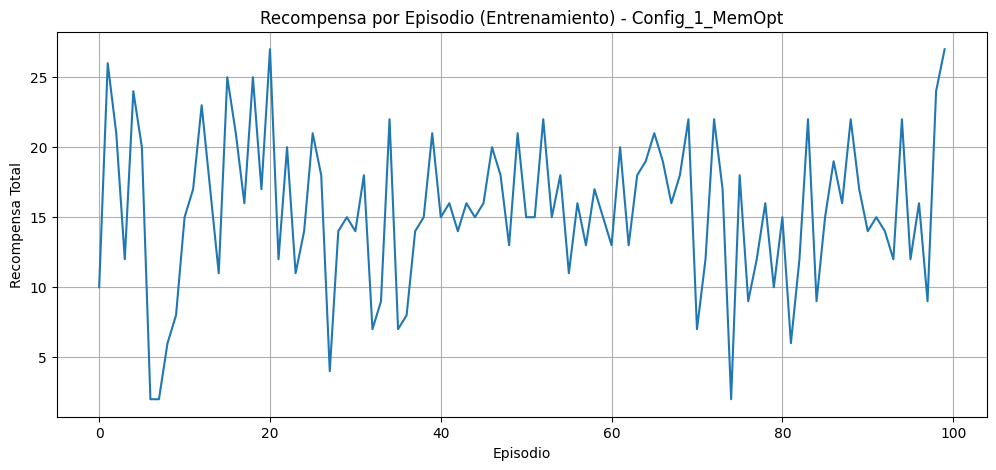

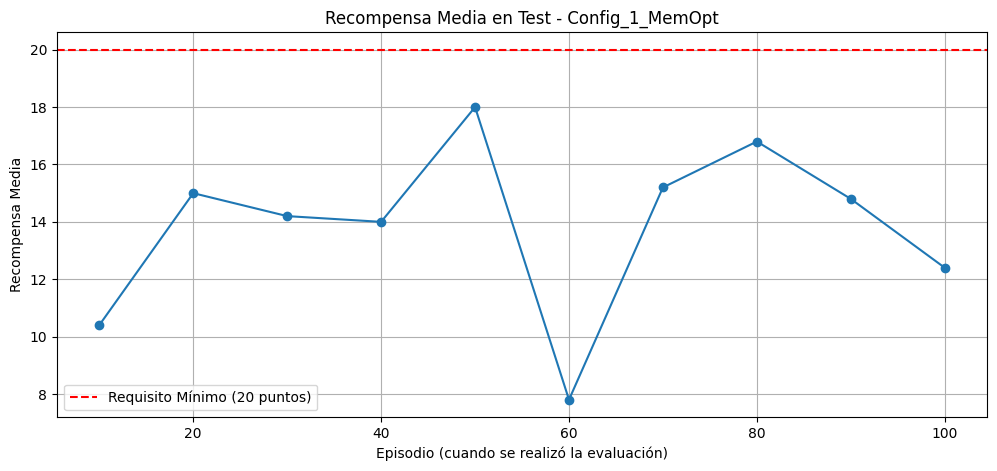


--- Iniciando entrenamiento para: Config_2_MemOpt ---
Parámetros: {'buffer_size': 3000, 'batch_size': 64, 'gamma': 0.99, 'lr': 5e-05, 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 7500, 'target_update_freq': 750, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 19.00, Epsilon: 0.1074
Episodio 2/100, Recompensa: 8.00, Epsilon: 0.0103
Episodio 3/100, Recompensa: 19.00, Epsilon: 0.0100
Episodio 4/100, Recompensa: 13.00, Epsilon: 0.0100
Episodio 5/100, Recompensa: 12.00, Epsilon: 0.0100
Episodio 6/100, Recompensa: 8.00, Epsilon: 0.0100
Episodio 7/100, Recompensa: 17.00, Epsilon: 0.0100
Episodio 8/100, Recompensa: 15.00, Epsilon: 0.0100
Episodio 9/100, Recompensa: 10.00, Epsilon: 0.0100
Episodio 10/100, Recompensa: 20.00, Epsilon: 0.0100
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 16.80
Episodio 11/100, Recompensa: 12.00, Epsilon: 0.0100
Episodio 12/100, Recompensa: 13

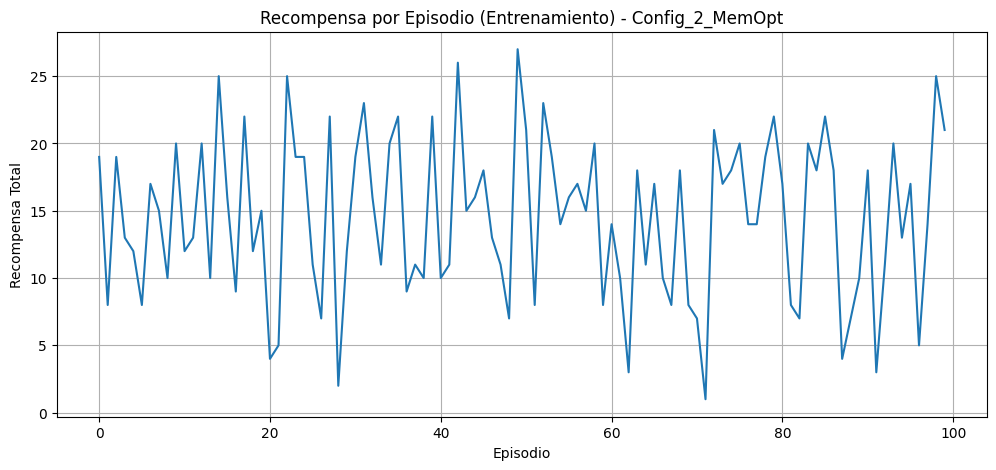

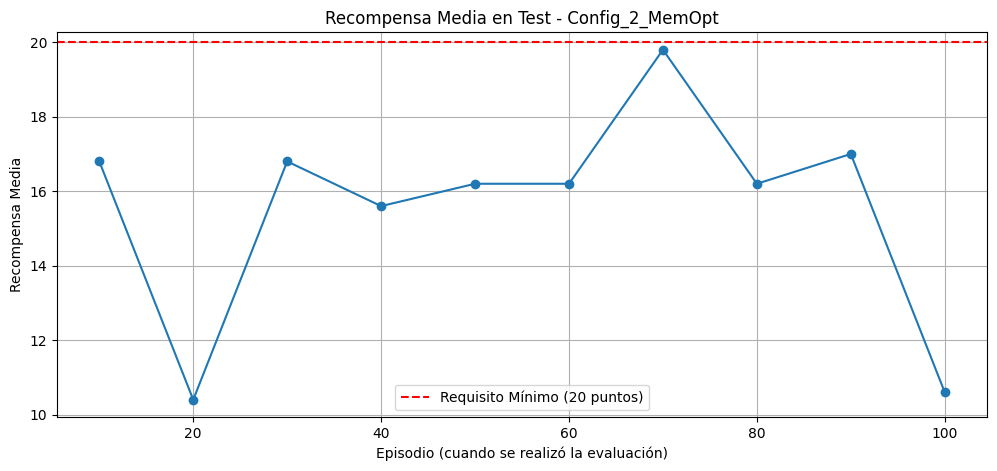


--- Iniciando entrenamiento para: Config_3_MemOpt ---
Parámetros: {'buffer_size': 2500, 'batch_size': 32, 'gamma': 0.95, 'lr': 0.0001, 'epsilon_start': 0.8, 'epsilon_end': 0.05, 'epsilon_decay': 4000, 'target_update_freq': 500, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 4.00, Epsilon: 0.2622
Episodio 2/100, Recompensa: 5.00, Epsilon: 0.0500
Episodio 3/100, Recompensa: 9.00, Epsilon: 0.0500
Episodio 4/100, Recompensa: 11.00, Epsilon: 0.0500
Episodio 5/100, Recompensa: 19.00, Epsilon: 0.0500
Episodio 6/100, Recompensa: 14.00, Epsilon: 0.0500
Episodio 7/100, Recompensa: 11.00, Epsilon: 0.0500
Episodio 8/100, Recompensa: 19.00, Epsilon: 0.0500
Episodio 9/100, Recompensa: 19.00, Epsilon: 0.0500
Episodio 10/100, Recompensa: 17.00, Epsilon: 0.0500
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 18.60
Episodio 11/100, Recompensa: 11.00, Epsilon: 0.0500
Episodio 12/100, Recompensa: 16

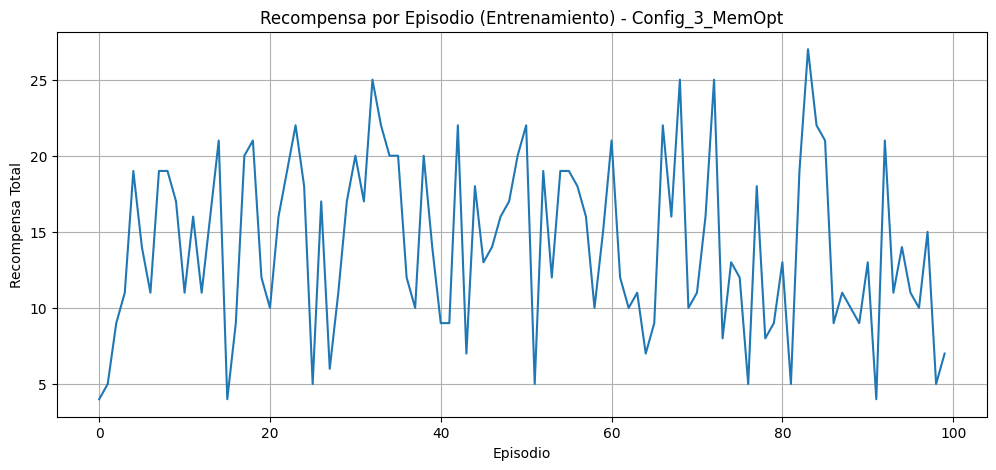

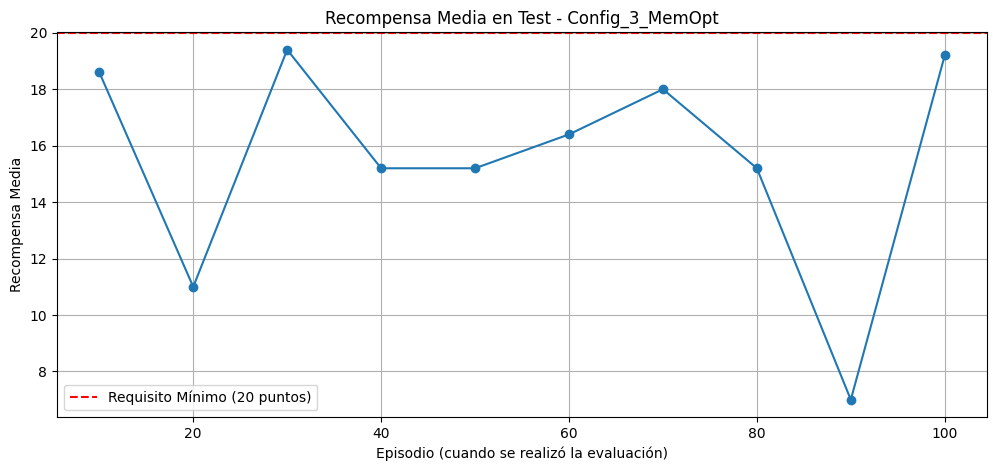


--- Iniciando entrenamiento para: Config_4_MemOpt ---
Parámetros: {'buffer_size': 3500, 'batch_size': 32, 'gamma': 0.995, 'lr': 0.0002, 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 6000, 'target_update_freq': 600, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 11.00, Epsilon: 0.0285
Episodio 2/100, Recompensa: 2.00, Epsilon: 0.0105
Episodio 3/100, Recompensa: 5.00, Epsilon: 0.0100
Episodio 4/100, Recompensa: 15.00, Epsilon: 0.0100
Episodio 5/100, Recompensa: 9.00, Epsilon: 0.0100
Episodio 6/100, Recompensa: 19.00, Epsilon: 0.0100
Episodio 7/100, Recompensa: 21.00, Epsilon: 0.0100
Episodio 8/100, Recompensa: 8.00, Epsilon: 0.0100
Episodio 9/100, Recompensa: 17.00, Epsilon: 0.0100
Episodio 10/100, Recompensa: 24.00, Epsilon: 0.0100
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 9.80
Episodio 11/100, Recompensa: 6.00, Epsilon: 0.0100
Episodio 12/100, Recompensa: 15.0

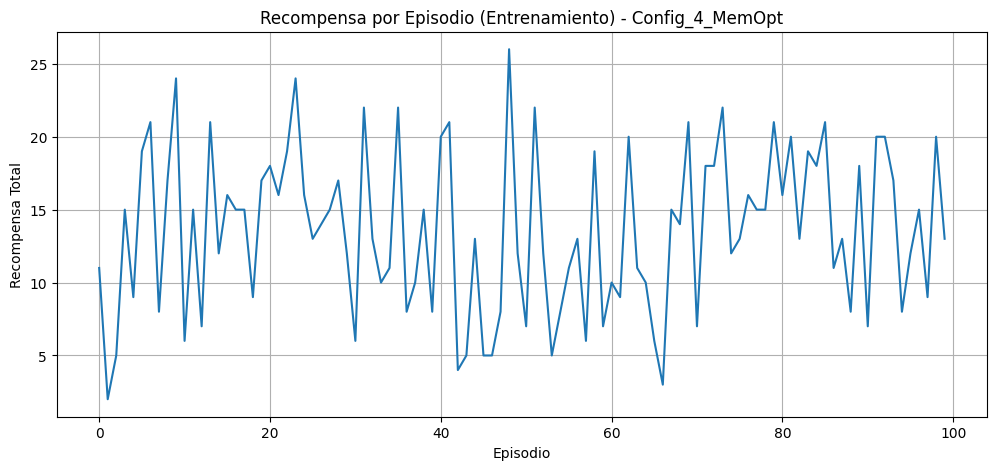

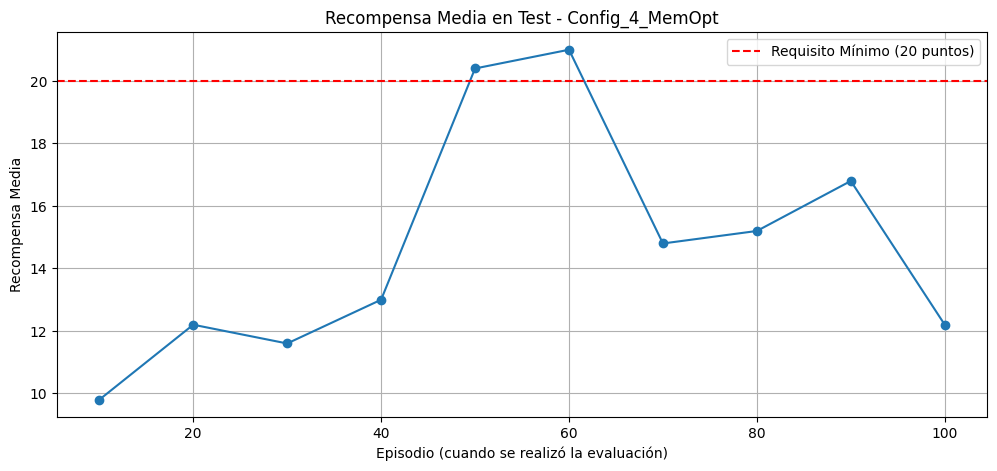


--- Iniciando entrenamiento para: Config_5_LongerExplore_MemOpt ---
Parámetros: {'buffer_size': 2000, 'batch_size': 32, 'gamma': 0.99, 'lr': 0.0001, 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 15000, 'target_update_freq': 500, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 6.00, Epsilon: 0.6979
Episodio 2/100, Recompensa: 6.00, Epsilon: 0.2798
Episodio 3/100, Recompensa: 3.00, Epsilon: 0.0202
Episodio 4/100, Recompensa: 16.00, Epsilon: 0.0100
Episodio 5/100, Recompensa: 6.00, Epsilon: 0.0100
Episodio 6/100, Recompensa: 4.00, Epsilon: 0.0100
Episodio 7/100, Recompensa: 4.00, Epsilon: 0.0100
Episodio 8/100, Recompensa: 4.00, Epsilon: 0.0100
Episodio 9/100, Recompensa: 19.00, Epsilon: 0.0100
Episodio 10/100, Recompensa: 3.00, Epsilon: 0.0100
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 13.40
Episodio 11/100, Recompensa: 14.00, Epsilon: 0.0100
Episodio 12/100, Reco

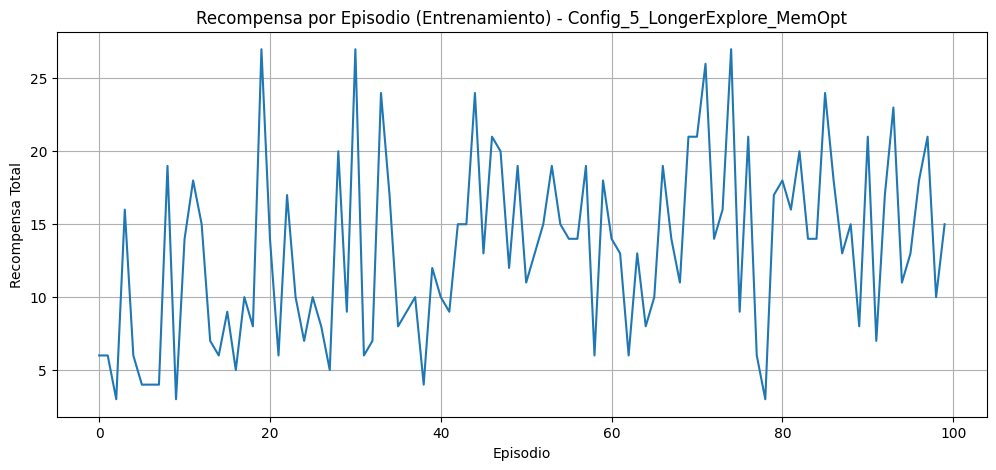

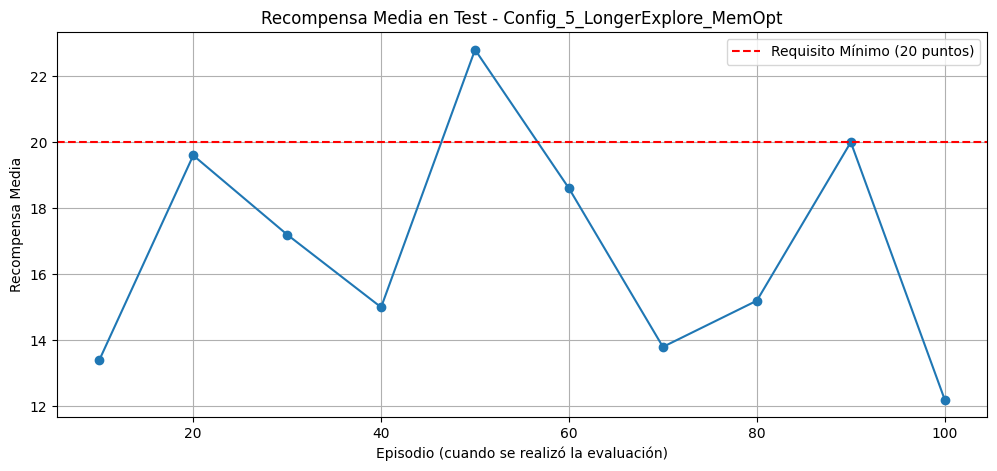


--- Iniciando entrenamiento para: Config_6_SlowTargetUpdate_MemOpt ---
Parámetros: {'buffer_size': 2000, 'batch_size': 32, 'gamma': 0.99, 'lr': 0.0001, 'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 5000, 'target_update_freq': 2000, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 18.00, Epsilon: 0.0363
Episodio 2/100, Recompensa: 3.00, Epsilon: 0.0105
Episodio 3/100, Recompensa: 1.00, Epsilon: 0.0100
Episodio 4/100, Recompensa: 10.00, Epsilon: 0.0100
Episodio 5/100, Recompensa: 21.00, Epsilon: 0.0100
Episodio 6/100, Recompensa: 6.00, Epsilon: 0.0100
Episodio 7/100, Recompensa: 18.00, Epsilon: 0.0100
Episodio 8/100, Recompensa: 13.00, Epsilon: 0.0100
Episodio 9/100, Recompensa: 5.00, Epsilon: 0.0100
Episodio 10/100, Recompensa: 3.00, Epsilon: 0.0100
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 10.60
Episodio 11/100, Recompensa: 19.00, Epsilon: 0.0100
Episodio 12/100

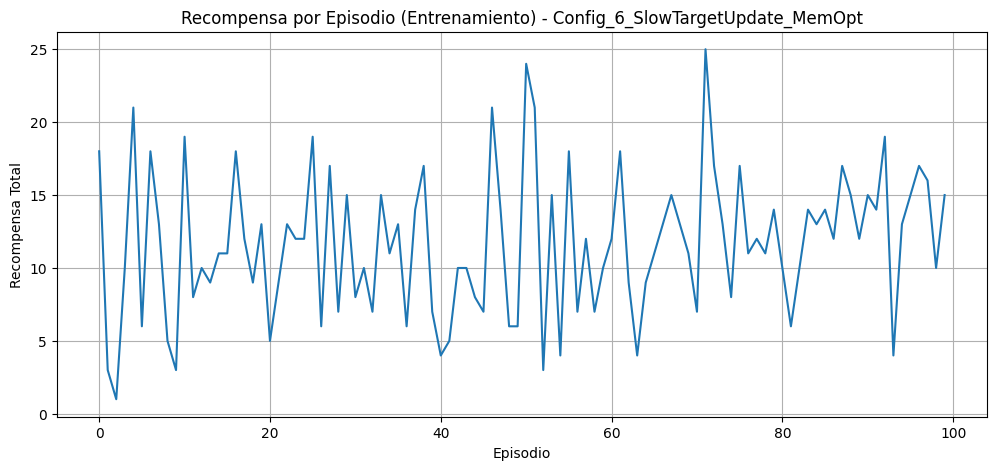

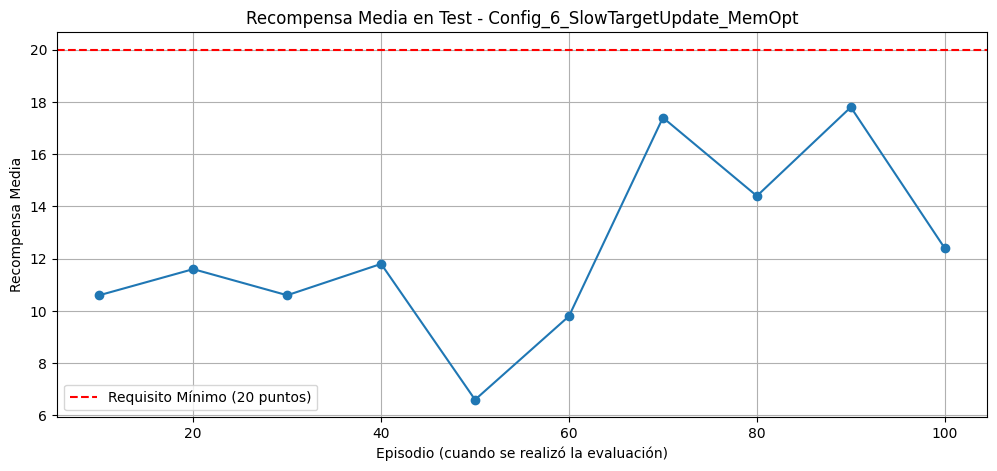


--- Iniciando entrenamiento para: Config_7_HighGamma_LowLR_MemOpt ---
Parámetros: {'buffer_size': 3000, 'batch_size': 64, 'gamma': 0.999, 'lr': 1e-05, 'epsilon_start': 1.0, 'epsilon_end': 0.005, 'epsilon_decay': 7500, 'target_update_freq': 750, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 2.00, Epsilon: 0.7460
Episodio 2/100, Recompensa: 12.00, Epsilon: 0.0120
Episodio 3/100, Recompensa: 16.00, Epsilon: 0.0050
Episodio 4/100, Recompensa: 16.00, Epsilon: 0.0050
Episodio 5/100, Recompensa: 10.00, Epsilon: 0.0050
Episodio 6/100, Recompensa: 11.00, Epsilon: 0.0050
Episodio 7/100, Recompensa: 24.00, Epsilon: 0.0050
Episodio 8/100, Recompensa: 24.00, Epsilon: 0.0050
Episodio 9/100, Recompensa: 25.00, Epsilon: 0.0050
Episodio 10/100, Recompensa: 7.00, Epsilon: 0.0050
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 24.60
Episodio 11/100, Recompensa: 21.00, Epsilon: 0.0050
Episodio 12/1

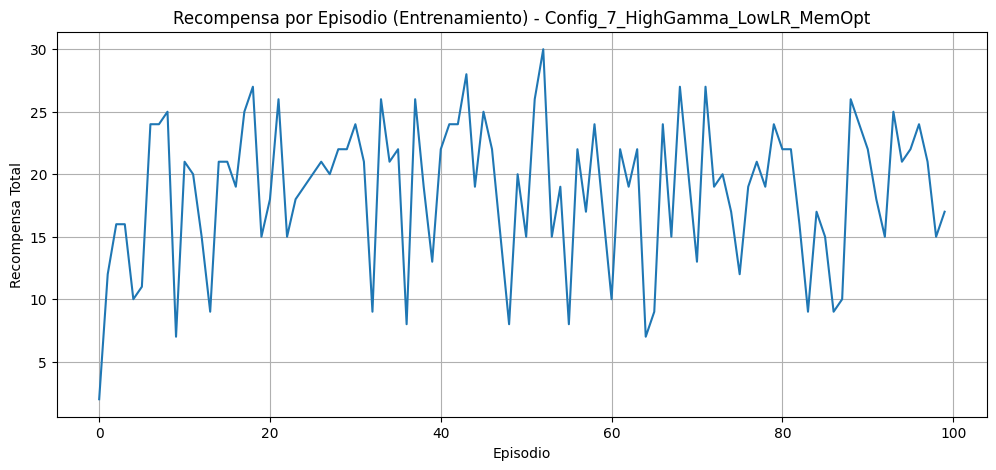

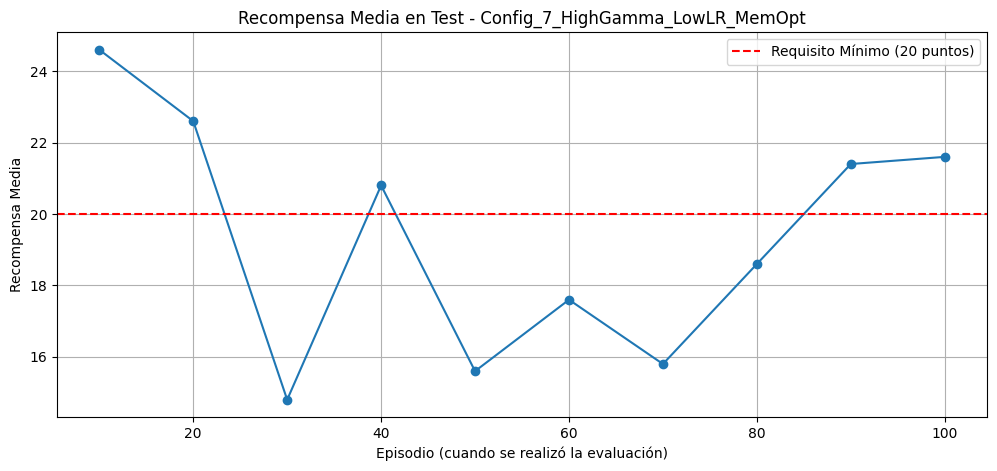


--- Iniciando entrenamiento para: Config_8_LowerGamma_HigherLR_MemOpt ---
Parámetros: {'buffer_size': 2000, 'batch_size': 32, 'gamma': 0.98, 'lr': 0.0005, 'epsilon_start': 0.9, 'epsilon_end': 0.02, 'epsilon_decay': 5000, 'target_update_freq': 500, 'total_episodes': 100, 'max_steps_per_episode': 250, 'eval_interval': 10}
Episodio 1/100, Recompensa: 8.00, Epsilon: 0.3803
Episodio 2/100, Recompensa: 8.00, Epsilon: 0.0200
Episodio 3/100, Recompensa: 8.00, Epsilon: 0.0200
Episodio 4/100, Recompensa: 9.00, Epsilon: 0.0200
Episodio 5/100, Recompensa: 4.00, Epsilon: 0.0200
Episodio 6/100, Recompensa: 10.00, Epsilon: 0.0200
Episodio 7/100, Recompensa: 14.00, Epsilon: 0.0200
Episodio 8/100, Recompensa: 12.00, Epsilon: 0.0200
Episodio 9/100, Recompensa: 4.00, Epsilon: 0.0200
Episodio 10/100, Recompensa: 15.00, Epsilon: 0.0200
--- Evaluando modelo después de 10 episodios ---
Media de recompensa en test (últimos 5 episodios): 10.20
Episodio 11/100, Recompensa: 13.00, Epsilon: 0.0200
Episodio 12/10

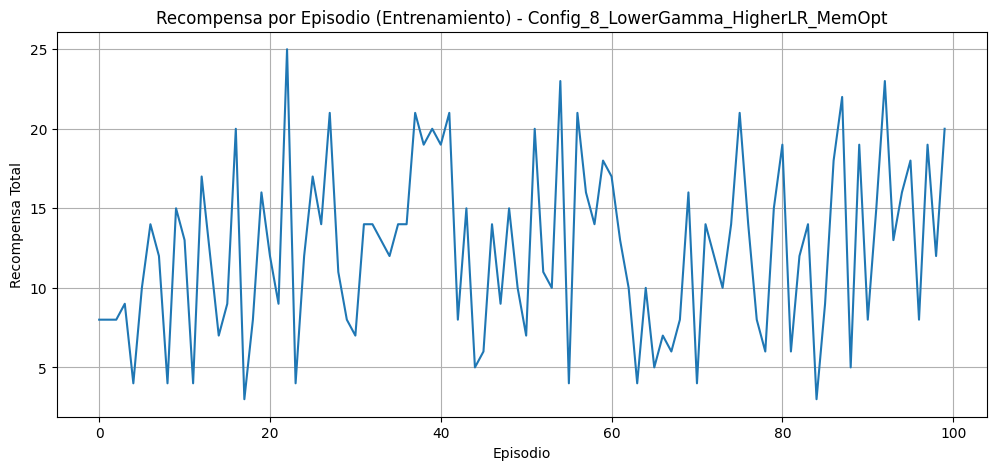

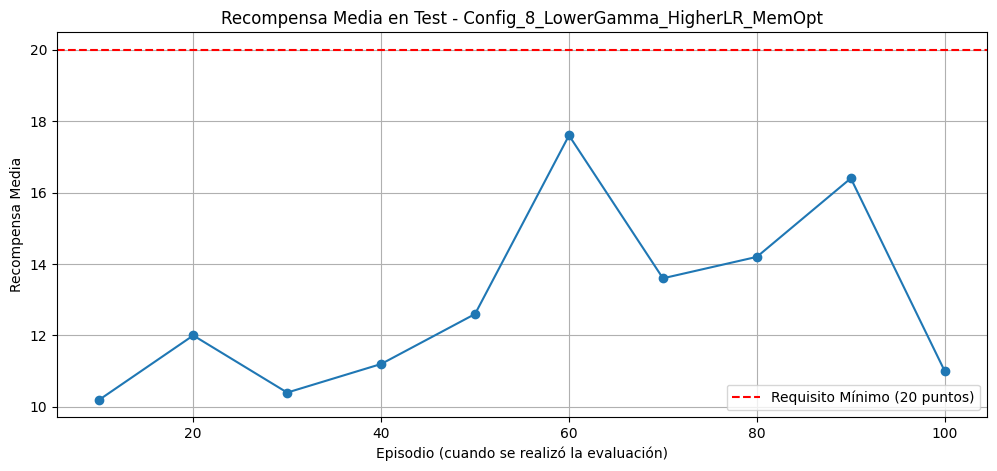


--- ¡Entrenamiento de todas las configuraciones completado! ---


In [6]:
# Entrenamiento
all_run_results = {}

for config_name, params in param_configs.items():
    print(f"\n--- Iniciando entrenamiento para: {config_name} ---")
    print(f"Parámetros: {params}")

    agent = DQNAgent(
        state_shape=state_shape,
        n_actions=n_actions,
        buffer_size=params["buffer_size"],
        batch_size=params["batch_size"],
        gamma=params["gamma"],
        lr=params["lr"],
        epsilon_start=params["epsilon_start"],
        epsilon_end=params["epsilon_end"],
        epsilon_decay=params["epsilon_decay"],
        target_update_freq=params["target_update_freq"]
    )

    episode_rewards = []
    test_rewards_history = []

    for episode in range(1, params["total_episodes"] + 1):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done and steps < params["max_steps_per_episode"]:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

            agent.optimize_model()

        episode_rewards.append(total_reward)
        print(f"Episodio {episode}/{params['total_episodes']}, Recompensa: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

        # Evaluación en modo test
        if episode % params["eval_interval"] == 0:
            print(f"--- Evaluando modelo después de {episode} episodios ---")
            test_rewards = []
            num_test_episodes = 5 # Número de episodios para la evaluación

            for test_episode in range(num_test_episodes):
                state = env.reset()
                done = False
                episode_test_reward = 0
                while not done:
                    # En modo test, siempre usamos la política greedy (sin exploración)
                    with torch.no_grad():
                        state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
                        action = agent.policy_net(state_tensor).argmax(1).item()

                    state, reward, done, _ = env.step(action)
                    episode_test_reward += reward
                test_rewards.append(episode_test_reward)

            avg_test_reward = np.mean(test_rewards)
            test_rewards_history.append((episode, avg_test_reward))
            print(f"Media de recompensa en test (últimos {num_test_episodes} episodios): {avg_test_reward:.2f}")

    # Guardamos resultados y modelo para la configuración actual
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = os.path.join(results_dir, f"{config_name}_model_{current_time}.pth")
    agent.save_model(model_save_path)
    print(f"Modelo guardado en: {model_save_path}")



    # Guardamos el historial de recompensas y test
    results_file_path = os.path.join(results_dir, f"{config_name}_results_{current_time}.txt")
    with open(results_file_path, "w") as f:
        f.write(f"Configuración: {config_name}\n")
        f.write(f"Parámetros: {params}\n")
        f.write("\nRecompensas por episodio (entrenamiento):\n")
        for i, r in enumerate(episode_rewards):
            f.write(f"Episodio {i+1}: {r:.2f}\n")
        f.write("\nRecompensa media en modo test:\n")
        for ep, avg_rew in test_rewards_history:
            f.write(f"Episodio {ep}: {avg_rew:.2f}\n")
    print(f"Resultados guardados en: {results_file_path}")

    all_run_results[config_name] = {
        "episode_rewards": episode_rewards,
        "test_rewards_history": test_rewards_history,
        "model_path": model_save_path,
        "results_file_path": results_file_path
    }

    # Graficas recompensas de entrenamiento
    plt.figure(figsize=(12, 5))
    plt.plot(episode_rewards)
    plt.title(f'Recompensa por Episodio (Entrenamiento) - {config_name}')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total')
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f"{config_name}_training_rewards.png"))
    plt.show()

    # Graficas recompensas de test
    if test_rewards_history:
        episodes_eval, avg_rewards_eval = zip(*test_rewards_history)
        plt.figure(figsize=(12, 5))
        plt.plot(episodes_eval, avg_rewards_eval, marker='o')
        plt.title(f'Recompensa Media en Test - {config_name}')
        plt.xlabel('Episodio (cuando se realizó la evaluación)')
        plt.ylabel('Recompensa Media')
        plt.axhline(y=20, color='r', linestyle='--', label='Requisito Mínimo (20 puntos)')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(results_dir, f"{config_name}_test_rewards.png"))
        plt.show()

print("\n--- ¡Entrenamiento de todas las configuraciones completado! ---")
